In [1]:
import sys
sys.path.append("../scripts/")
from robot import *
from scipy.stats import multivariate_normal

In [2]:
class Particle:
    def __init__(self, init_pose):
        self.pose = init_pose
    
    def motion_update(self, nu, omega, time, noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        noised_nu = nu + ns[0] * math.sqrt(abs(nu)/time) + ns[1] * math.sqrt(abs(omega)/time)
        noised_omega = omega + ns[2] * math.sqrt(abs(nu)/time) + ns[3] * math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(noised_nu, noised_omega, time, self.pose)

In [3]:
class Mcl:
    def __init__(self, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, nu, omega, time):
        for p in self.particles:
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
        
    def draw(self, ax, elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles]
        vys = [math.sin(p.pose[2]) for p in self.particles]
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
    
    def decision(self, observation=None):
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)

In [5]:
initial_pose = np.array([0, 0, 0]).T
estimator = Mcl(initial_pose, 100, motion_noise_stds={"nn":0.01, "no":0.02, "on":0.03, "oo":0.04})
a = EstimationAgent(0.1, 0.2, 10.0/180*math.pi, estimator)
estimator.motion_update(0.2, 10.0/180*math.pi, 0.1)
for p in estimator.particles:
    print(p.pose)

[1.64132918e-02 9.40735367e-05 1.14629664e-02]
[2.11265735e-02 5.36499479e-05 5.07889578e-03]
[0.02392111 0.00012756 0.01066525]
[0.02005744 0.00024149 0.02407873]
[0.02088457 0.00016841 0.01612696]
[0.01736967 0.00019067 0.02195326]
[0.01567959 0.00015931 0.02031956]
[0.02172575 0.00039721 0.0365613 ]
[0.02383908 0.00028265 0.02371186]
[0.01544572 0.00015506 0.02007725]
[0.01731832 0.00014083 0.01626373]
[0.01976749 0.00027569 0.02789168]
[0.01962752 0.00016586 0.01690061]
[1.91144729e-02 9.99592229e-05 1.04589137e-02]
[0.01858533 0.00019808 0.02131544]
[0.0219827  0.00018257 0.01661031]
[0.02322078 0.00015397 0.01326091]
[0.01775145 0.00022925 0.02582758]
[0.02670184 0.00023154 0.0173419 ]
[0.02280039 0.0002399  0.02104261]
[0.02550555 0.0003773  0.02958395]
[0.01792629 0.00022004 0.02454833]
[0.01639959 0.00020208 0.02464309]
[0.02222925 0.00023439 0.02108768]
[1.80867262e-02 2.94752957e-05 3.25932613e-03]
[0.01932713 0.00014852 0.01536884]
[0.01753099 0.00015066 0.01718697]
[1.7674

<IPython.core.display.Javascript object>


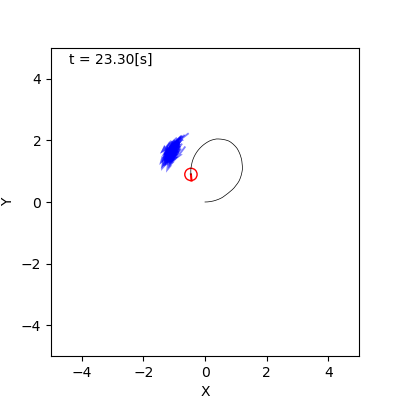

In [6]:
def trial(motion_noise_stds):
    time_interval = 0.1
    world = World(30, time_interval, debug=False)
    
    initial_pose = np.array([0, 0, 0]).T
    estimator = Mcl(initial_pose, 100, motion_noise_stds)
    circling = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, estimator)
    r = Robot(initial_pose, sensor=None, agent=circling, color="red")
    world.append(r)
    
    world.draw()

trial({"nn":0.01, "no":0.02, "on":0.03, "oo":0.04})

<IPython.core.display.Javascript object>


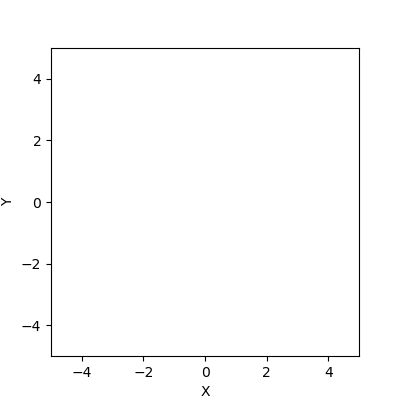

In [7]:
time_interval = 0.1
world = World(40, time_interval, debug=False)

initial_pose = np.array([0, 0, 0]).T
motion_noise_stds = {"nn": 0.001, "no":0.001, "on": 0.13, "oo":0.001}
e = Mcl(initial_pose, 100, motion_noise_stds)
c = EstimationAgent(time_interval, 0.1, 0.0, e)
r = Robot(initial_pose, sensor=None, agent=c, color='red')
world.append(r)

world.draw()


<IPython.core.display.Javascript object>


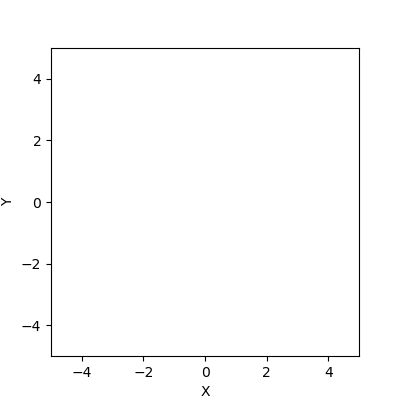

In [8]:
time_interval = 0.1
world = World(30, time_interval, debug=False)

initial_pose = np.array([0, 0, 0]).T
e = Mcl(initial_pose, 100)
c = EstimationAgent(time_interval, 0.2, 10/180*math.pi, e)
r = Robot(initial_pose, sensor=None, agent=c, color='red')
world.append(r)

world.draw()

<IPython.core.display.Javascript object>


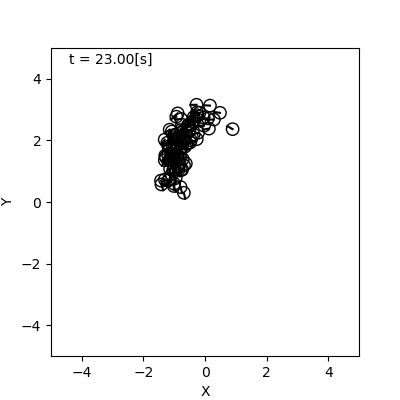

In [9]:
time_interval = 0.1
world = World(30, time_interval, debug=False)

initial_pose = np.array([0, 0, 0]).T
for i in range(100):
    r = Robot(initial_pose, sensor=None, agent=Agent(0.2, 10/180*math.pi), orbit=False)
    world.append(r)
    
world.draw()

    